# AUC MAP

In [2]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import sklearn.metrics as metrics
import random

from os import path
import tqdm

from training_bert import BertNliLight
from custom_data_set import SnliDataset
from custom_data_set import test_dir
from torch.utils.data import DataLoader

from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.raw_attention import normalize_attention
from attention_algorithms.raw_attention import hightlight_txt
from attention_algorithms.attention_metrics import default_plot_colormap

from IPython.display import display, HTML

# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ", end="")
print(os.getcwd())

# the folder where we will save our data
plots_folder = os.path.join(os.getcwd(), '.cache', 'plots')
graph_folder = path.join(plots_folder, "auc_head_map")
if not path.exists(path.join(plots_folder, "auc_head_map")):
    os.mkdir(path.join(plots_folder, "auc_head_map"))

print(f">> the plots location : {graph_folder}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm
>> the plots location : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\.cache\plots\auc_head_map


In [3]:
# load the model

ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model.eval()  # make sure to have the model in eval mod before using it

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertNliLight(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [4]:
# load the data
data_set = SnliDataset(dir=test_dir, nb_sentences=1000, msg=False)
data_loader = DataLoader(data_set, batch_size=1000, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

print(f">> shape of the sentences : {sentences.shape}")
print(f">> shape of the masks : {masks.shape}")

>> shape of the sentences : torch.Size([1000, 150])
>> shape of the masks : torch.Size([1000, 150])


In [5]:
# the data we annotated.
e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'test.csv'), sep=",")\
    [["tok_sent", "hg_goal"]]
e_snli_data.head()

,tok_sent,hg_goal
0,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## The AUC Map

---

The objective here is for each head $h$ of each layer $l$ to have the information whether or not it will provide a plausible explanation. We want to study each head separately to see if some heads are useful and thus prune the useless heads.

As a reminder, for each sentence $s$ composed of $T(s)$ (T is the function that count the number of tokens in a sentence) tokens for each head $h$ and for each layer $l$ we have a matrix $head_{l,h}(s) \in [0,1]^{T(s)\times T(s)}$ This is the attention. Because it is the attention we have the following property :
$$
\sum_{j=0}^{T-1}\quad head_{l,h}(s)[i,j] = 1 \quad \quad \forall i \in \{0,\dots, T-1\}
$$

Because the attention is a result of a softmax.
Then for every token $j$ in our sentence $s$, given a head $h$ and a layer $l$ we will compute its attention score :
$$
a_{h,l}^{s,j} = \sum_{i=0}^{T-1}\quad head_{l,h}(s)[i,j]\quad \quad \forall j \in \{0,1,\dots,T-1\}
$$

In the next cell for every token of every sentence we will compute this attention score that we will normalize over a sentence, and then for every head $h$ of the layer $l$ we will have $ \hat{a}_{h,l} \in [0,1]^{\mathcal{T}} $ the attention weights calculated for every token that we normalize over each sentence where $\mathcal{T}$ is the number of tokens cumulated on all the sentences of our corpus. Against this vector we will have the vector $e^{snli} \in \{0,1\}^{\mathcal{T}}$ which is the annotation vector for every tokens which comes from the e-snli data-set.




In [6]:
class LenException(Exception):
    pass

SPECIAL_TOKENS = ["[CLS]", "[SEP]", "[PAD]"]

Y_test = []

nb_err = 0

# where we
pur_attention = {}

for i in range(12):
    pur_attention[f"layer_{i}"] = {}
    for j in range(12):
        pur_attention[f"layer_{i}"][f"head_{j}"] = []


for _, i in enumerate(tqdm.tqdm(range(1000))):
    j = 0
    # iteration through all the sentences
    # construct the raw attention object
    sent = sentences[i, :].clone().detach()[None,:]
    mk = masks[i, :].clone().detach()[None,:]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # find the e-snli sentence that corresponds to our problem
    try :
        while j<e_snli_data.shape[0] and raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
            j+=1

        if j>=e_snli_data.shape[0]:
            raise LenException

        if raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
            raise LenException

        else :
            # once the sentence is found >> add the e-snli annotation
            Y_test += eval(e_snli_data["hg_goal"][j])

            # loop over every head of every layer
            for l in range(12):
                for h in range(12):
                    mat = raw_attention_inst.attention_tensor[0, l ,h, :, :]

                    # make the sum on the column >> agregation of the weights
                    # >> dim=0 >> we reduce the number of lines
                    b = mat.sum(dim=0)

                    # >> remove the special tokens
                    # >> normalize the attention
                    b = normalize_attention(raw_attention_inst.tokens, b)

                    # >> add the attention
                    pur_attention[f"layer_{l}"][f"head_{h}"] += list(b.detach().numpy())




    except LenException :
        # count the different errors
        nb_err += 1


# >> the errors are for the sentences we didn't found in the snli dataset
print(f">> nb_errors : {nb_err}")

# how many labeled example do we have
print(f">> len Y_test : {len(Y_test)}")

100%|██████████| 1000/1000 [04:29<00:00,  3.71it/s]

>> nb_errors : 21
>> len Y_test : 26600


Then we have for every head $h$ of every layer $l$, we have the two vectors $\hat{a}_{h,l}$ and $e^{snli}$. The AUC map will only be a matrix $auc\_map\in [0,1]^{L\times H}$ where :
$$
auc\_map[l,h] = AUC(\hat{a}_{h,l}~,~ e^{snli})
$$

With $AUC$ the Area under the roc curve metric.

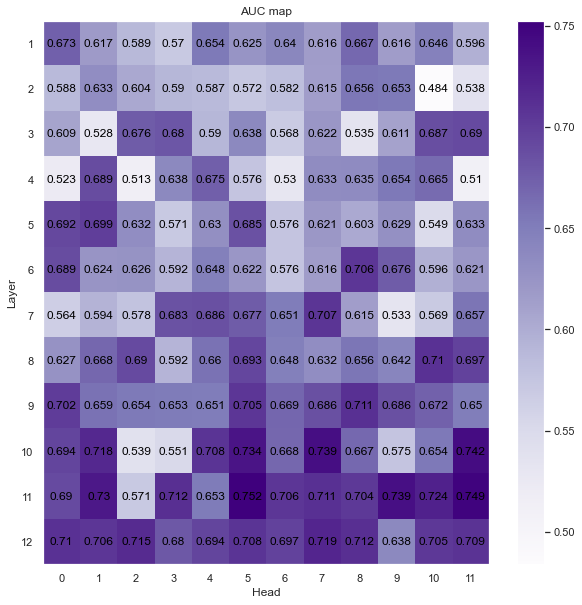

In [7]:
# Construction of the AUC map
auc_map = np.zeros((12,12))
for l in range(12):
    for h in range(12):
        preds = pur_attention[f"layer_{l}"][f"head_{h}"]
        fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
        auc_map[l,h] = metrics.auc(fpr, tpr)

# plot the color map
fig = default_plot_colormap(auc_map, xlabel="Head", ylabel="Layer", title="AUC map")
plt.savefig(os.path.join(graph_folder,"auc_map.png"))
plt.show()

We can make here some really interesting comments :

- first the maximum value for the *AUC* on this map is $\approx 0.75$. This is a really high *plausibility score*. The *AUC* provided here is much better than the *AUC* provided by the flow max problem
- for every head of every layer we have an *AUC* greater than $0.5$ this means that every layer provide a plausible explanation (better than a random explanation).
- the layer **11** is really interesting and provide an *AUC* score higher than the other layers (a focus on this layer will be made later).
- the heads with an AUC near $0.5$ provide a useless information. $0.5$ is the worst AUC we can obtain.
- we will retain the head 5 of the layer 11. Then to access the best head we will do attention_tensor[0,10,5], the heads are numbered from 0 to 11 but the layers are numbered from 1 to 12 because in the transformers architecture the layer 0 is the non-contextual embedding layer (that we do not study here).

## HTML visualisation (look deeply into the heads)

---

We will look at the highlighted words and compare it with the e-snli annotation. We want to be convinced that some heads have really no mean in terms of plausibility analysis.

In [8]:
sent_choice = random.randint(0,1000)
print(f">> we will look at the sentence : {sent_choice}")

>> we will look at the sentence : 291


In [13]:
# visualize on the best head
try :
    sent = sentences[sent_choice, :].clone().detach()[None,:]
    mk = masks[sent_choice, :].clone().detach()[None,:]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # construction of the attention score
    attention_score = raw_attention_inst.attention_tensor[0,10,5,:,:].sum(dim=0)
    # noramlization of the score
    attention_score = normalize_attention(raw_attention_inst.tokens, attention_score)
    # we will now earch the e-snli corresponding sentence
    j = 0

    while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens :
        j += 1

    vis = hightlight_txt(raw_attention_inst.tokens, attention_score, torch.tensor(eval(e_snli_data["hg_goal"][j])))
    display(HTML(vis))

except Exception :
    print("sentences problems")

In [14]:
# visualize the worst head
try :
    sent = sentences[sent_choice, :].clone().detach()[None,:]
    mk = masks[sent_choice, :].clone().detach()[None,:]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # construction of the attention score >> here we take the layer 4 and the head 2
    attention_score = raw_attention_inst.attention_tensor[0,3,2,:,:].sum(dim=0)
    # normalization of the score
    attention_score = normalize_attention(raw_attention_inst.tokens, attention_score)
    while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens :
        j += 1
    # attention visu
    vis = hightlight_txt(raw_attention_inst.tokens, attention_score, torch.tensor(eval(e_snli_data["hg_goal"][j])))
    display(HTML(vis))

except Exception :
    print("sentences problems")

In [58]:
# the number of 1 we have in our dataset
# >> we don't mark a lot of data
print(f"ratio of 1 label in e-snli data : {np.round(sum(Y_test)/len(Y_test)*100,3)} %")

ratio of 1 label in e-snli data : 19.32 %


Here also we can make some observation :
- Our hypothesis that some head aren't usefull seems to be true since some heads provide an annotation which is really bad.
- On the other hand some heads seems to be really interesting with an *AUC* $\approx 0.75$, but we have to be really carefull about this because this result is good because of the ratio of 1 label in the Y_test. Since there is a really few number of 1 labels in this, if we have a score that provide very few

## Agregation of the "good" heads

---

After this experience we are able te see that some heads are "useless" (the AUC is really close to 0.5) we will then apply a mask to the head to focus on the head with a good AUC. To define a good AUC we need to set a threshold $TR$, and we will keep all the heads that have an AUC greater than this particular treshold

### Layer Sum agregation

---

We saw during the previous phase that some layers could be pruned be within the "important heads" (the heads we do not prune) each head provide an information different about the plausibility. Our objective is to combine the information gathered by each of these heads. A good way to combine this information is to make the *sum* (sum agregation).

First we will look at the sum layer by layer, we want to keep this approach layer by layer.

In [16]:
# the mask
TR = 0.6
auc_mask = (auc_map>TR)

In [17]:
class LenException(Exception):
    pass

SPECIAL_TOKENS = ["[CLS]", "[SEP]", "[PAD]"]

Y_test = []

nb_err = 0

# where we
pur_attention_bis = {}

for i in range(12):
    pur_attention_bis[f"layer_{i}"] = []


for _, i in enumerate(tqdm.tqdm(range(1000))):
    j = 0
    # iteration through all the sentences
    # construct the raw attention object
    sent = sentences[i, :].clone().detach()[None,:]
    mk = masks[i, :].clone().detach()[None,:]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # find the e-snli sentence that corresponds to our problem
    try :
        while j<e_snli_data.shape[0] and raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
            j+=1

        if j>=e_snli_data.shape[0]:
            raise LenException

        if raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
            raise LenException

        else :
            # once the sentence is found >> add the e-snli annotation
            Y_test += eval(e_snli_data["hg_goal"][j])

            # loop over every head of every layer
            for l in range(12):
                # mat >> the attention of the layer
                mat = None
                # on this layer, sum of all the "good heads"
                # >> the good heads are found with the auc_mask we created
                # >> on each layer we sum the good layers
                for h in range(12):
                    if h==0:
                        m = raw_attention_inst.attention_tensor[0, l ,h, :, :].detach().numpy()
                        m *= int(auc_mask[l,h])
                        mat = m.copy()
                    else :
                        m = raw_attention_inst.attention_tensor[0, l ,h, :, :].detach().numpy()
                        m *= int(auc_mask[l,h])
                        mat += m.copy()

                mat = torch.tensor(mat)
                # make the sum on the column >> agregation of the weights
                # >> dim=0 >> we reduce the number of lines
                b = mat.sum(dim=0)

                # >> remove the special tokens
                # >> normalize the attention
                b = normalize_attention(raw_attention_inst.tokens, b)

                    # >> add the attention
                pur_attention_bis[f"layer_{l}"] += list(b.detach().numpy())




    except LenException :
        # count the different errors
        nb_err += 1


# >> the errors are for the sentences we didn't found in the snli dataset
print(f">> nb_errors : {nb_err}")

# how many labeled example do we have
print(f">> len Y_test : {len(Y_test)}")

100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s]

>> nb_errors : 21
>> len Y_test : 26600


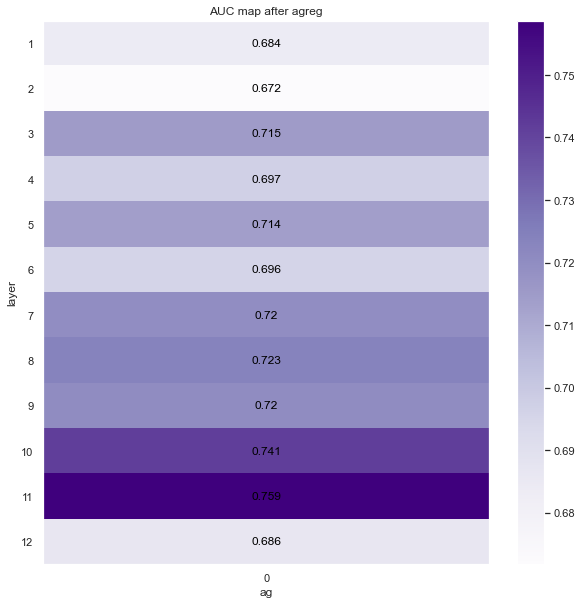

In [18]:
# Construction of the AUC map
auc_map_bis = np.zeros((12,1))
for l in range(12):
    preds = pur_attention_bis[f"layer_{l}"]
    fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
    auc_map_bis[l,0] = metrics.auc(fpr, tpr)

# plot the color map
fig = default_plot_colormap(auc_map_bis, xlabel="ag", ylabel="layer", title="AUC map after agreg")
plt.savefig(os.path.join(graph_folder,"auc_map_agreg_tr_06.png"))
plt.show()

In [21]:
# visualize on the best head
sent_choice = random.randint(0,1000)
print(f">> we will look at the sentence : {sent_choice}")

try :
    sent = sentences[sent_choice, :].clone().detach()[None,:]
    mk = masks[sent_choice, :].clone().detach()[None,:]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # construction of the attention score
    buff = raw_attention_inst.attention_tensor[0,10,:,:,:]
    attention_score = None
    # first we apply the mask
    for h in range(12):
        buff[h,:,:] *= int(auc_mask[10,h])

    attention_score = buff.sum(dim=0) # sum of all the heads
    attention_score = attention_score.sum(dim=0) # sum on the lines
    attention_score = normalize_attention(raw_attention_inst.tokens, attention_score)

    # we will now earch the e-snli corresponding sentence
    j = 0

    while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens :
        j += 1
    # attention visu
    vis = hightlight_txt(raw_attention_inst.tokens, attention_score, torch.tensor(eval(e_snli_data["hg_goal"][j])))
    display(HTML(vis))

except Exception :
    print("sentences problems")

>> we will look at the sentence : 315


#### Study of the threshold for the sum agregation

We saw that some heads provided a really bad AUC score, but what is a bad AUC score. In this next cell we will find the minimum AUC score that is good for a head and if we prune the heads with a bad AUC score do we improve the performance Layer by layer.

In [ ]:
TR_s = np.linspace(0.5,0.65,10) # where we will search the threshold

Tr_auc_map = np.zeros((12,len(TR_s)))

for _, k in enumerate(tqdm.tqdm(range(len(TR_s)))):
    tr = TR_s[k]

    auc_mask = (auc_map>tr)
    Y_test = []
    nb_err = 0

    pur_attention_bis = {}

    for i in range(12):
        pur_attention_bis[f"layer_{i}"] = []


    for i in range(1000):
        j = 0
        # iteration through all the sentences
        # construct the raw attention object
        sent = sentences[i, :].clone().detach()[None,:]
        mk = masks[i, :].clone().detach()[None,:]
        raw_attention_inst = RawAttention(model=model,
                                          input_ids=sent,
                                          attention_mask=mk,
                                          test_mod=False
                                          )

        # find the e-snli sentence that corresponds to our problem
        try :
            while j<e_snli_data.shape[0] and raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
                j+=1

            if j>=e_snli_data.shape[0]:
                raise LenException

            if raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
                raise LenException

            else :
                # once the sentence is found >> add the e-snli annotation
                Y_test += eval(e_snli_data["hg_goal"][j])

                # loop over every head of every layer
                for l in range(12):
                    # mat >> the attention of the layer
                    mat = None
                    # on this layer, sum of all the "good heads"
                    # >> the good heads are found with the auc_mask we created
                    # >> on each layer we sum the good layers
                    for h in range(12):
                        if h==0:
                            m = raw_attention_inst.attention_tensor[0, l ,h, :, :].detach().numpy()
                            m *= int(auc_mask[l,h])
                            mat = m.copy()
                        else :
                            m = raw_attention_inst.attention_tensor[0, l ,h, :, :].detach().numpy()
                            m *= int(auc_mask[l,h])
                            mat += m.copy()

                    mat = torch.tensor(mat)
                    # make the sum on the column >> agregation of the weights
                    # >> dim=0 >> we reduce the number of lines
                    b = mat.sum(dim=0)

                    # >> remove the special tokens
                    # >> normalize the attention
                    b = normalize_attention(raw_attention_inst.tokens, b)

                        # >> add the attention
                    pur_attention_bis[f"layer_{l}"] += list(b.detach().numpy())

        except LenException :
            # count the different errors
            nb_err += 1

    auc_map_bis = np.zeros((12,1))
    for l in range(12):
        preds = pur_attention_bis[f"layer_{l}"]
        fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
        auc_map_bis[l,0] = metrics.auc(fpr, tpr)

    Tr_auc_map[:,k] = auc_map_bis[:,0]

# plot the color map
fig = default_plot_colormap(Tr_auc_map, xstick=[str(np.round(t,3)) for t in TR_s] ,
                            xlabel="tr", ylabel="layer", title="AUC map tr + agreg")
plt.savefig(os.path.join(graph_folder,"auc_map_tr_search_for_agreg.png"))
plt.show()

Pruning and combining the heads seems to be something really interesting for our study

#### Study of the layer 11 (the best result we have)

##### AUC score of the layer 11

In [ ]:
# The TR_s we will look for
TR_s = [0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73]

Tr_auc_map = np.zeros((1,len(TR_s)))

for _, k in enumerate(tqdm.tqdm(range(len(TR_s)))):
    tr = TR_s[k]

    auc_mask = (auc_map>tr)
    Y_test = []
    nb_err = 0

    pur_attention_bis = []

    for i in range(1000):
        j = 0
        # iteration through all the sentences
        # construct the raw attention object
        sent = sentences[i, :].clone().detach()[None,:]
        mk = masks[i, :].clone().detach()[None,:]
        raw_attention_inst = RawAttention(model=model,
                                          input_ids=sent,
                                          attention_mask=mk,
                                          test_mod=False
                                          )

        # find the e-snli sentence that corresponds to our problem
        try :
            while j<e_snli_data.shape[0] and raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
                j+=1

            if j>=e_snli_data.shape[0]:
                raise LenException

            if raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
                raise LenException

            else :
                # once the sentence is found >> add the e-snli annotation
                Y_test += eval(e_snli_data["hg_goal"][j])

                # loop over every head of every layer
                mat = None
                # >> focus on the layer 11
                # agregation of the heads only on the layer 11
                # on this layer we can push the threshold
                for h in range(12):
                    if h==0:
                        m = raw_attention_inst.attention_tensor[0, 10 ,h, :, :].detach().numpy()
                        m *= int(auc_mask[10,h])
                        mat = m.copy()
                    else :
                        m = raw_attention_inst.attention_tensor[0, 10 ,h, :, :].detach().numpy()
                        m *= int(auc_mask[10,h])
                        mat += m.copy()

                mat = torch.tensor(mat)
                # make the sum on the column >> agregation of the weights
                # >> dim=0 >> we reduce the number of lines
                b = mat.sum(dim=0)

                # >> remove the special tokens
                # >> normalize the attention
                b = normalize_attention(raw_attention_inst.tokens, b)

                # >> add the attention
                pur_attention_bis += list(b.detach().numpy())

        except LenException :
            # count the different errors
            nb_err += 1


    preds = pur_attention_bis
    fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
    Tr_auc_map[0,k] = metrics.auc(fpr, tpr)

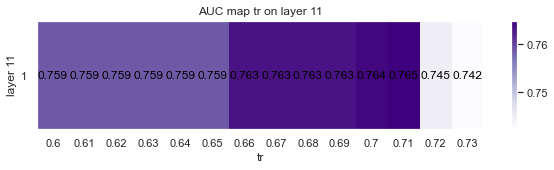

In [30]:
fig = default_plot_colormap(Tr_auc_map, xstick=[str(np.round(t,3)) for t in TR_s] ,
                            sz = (10,2),
                            xlabel="tr", ylabel="layer 11", title="AUC map tr on layer 11")
plt.savefig(os.path.join(graph_folder,"auc_map_tr_search_on_layer_11.png"))
plt.show()

##### HTML visu for the layer 11

In [31]:
TR = 0.71 # the best Threshold on the previous grid
auc_mask = (auc_map>TR)

In [33]:
# visualize on the best head
try :
    sent = sentences[sent_choice, :].clone().detach()[None,:]
    mk = masks[sent_choice, :].clone().detach()[None,:]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # construction of the attention score
    buff = raw_attention_inst.attention_tensor[0,10,:,:,:].detach().numpy()
    for h in range(12):
        buff[h] *= int(auc_mask[10,h])

    # sum of the heads
    attention_score = buff.sum(axis=0)
    # weight agregation
    attention_score = torch.tensor(attention_score.sum(axis=0))

    # noramlization of the score
    attention_score = normalize_attention(raw_attention_inst.tokens, attention_score)
    # we will now earch the e-snli corresponding sentence
    j = 0

    while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens :
        j += 1

    vis = hightlight_txt(raw_attention_inst.tokens, attention_score, torch.tensor(eval(e_snli_data["hg_goal"][j])))
    display(HTML(vis))

except Exception :
    print("sentences problems")

#### Global sum agregation

---

Instead of keeping the approach layer by layer we can have a more global approach

In [ ]:
TR_s = np.linspace(0.5,0.75,10) # where we will search the threshold

Tr_auc_map = np.zeros((1,len(TR_s)))

for _, k in enumerate(tqdm.tqdm(range(len(TR_s)))):
    tr = TR_s[k]

    auc_mask = (auc_map>tr)
    Y_test = []
    nb_err = 0

    pur_attention_bis = []


    for i in range(1000):
        j = 0
        # iteration through all the sentences
        # construct the raw attention object
        sent = sentences[i, :].clone().detach()[None,:]
        mk = masks[i, :].clone().detach()[None,:]
        raw_attention_inst = RawAttention(model=model,
                                          input_ids=sent,
                                          attention_mask=mk,
                                          test_mod=False
                                          )

        # find the e-snli sentence that corresponds to our problem
        try :
            while j<e_snli_data.shape[0] and raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
                j+=1

            if j>=e_snli_data.shape[0]:
                raise LenException

            if raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
                raise LenException

            else :
                # once the sentence is found >> add the e-snli annotation
                Y_test += eval(e_snli_data["hg_goal"][j])

                # this time the mat is something global for each layer
                mat = None
                # we will sum each "good" head
                for l in range(12):
                    for h in range(12):
                        if h==0:
                            m = raw_attention_inst.attention_tensor[0, l ,h, :, :].detach().numpy()
                            m *= int(auc_mask[l,h])
                            mat = m.copy()
                        else :
                            m = raw_attention_inst.attention_tensor[0, l ,h, :, :].detach().numpy()
                            m *= int(auc_mask[l,h])
                            mat += m.copy()

                mat = torch.tensor(mat)
                # make the sum on the column >> agregation of the weights
                # >> dim=0 >> we reduce the number of lines
                b = mat.sum(dim=0)

                # >> remove the special tokens
                # >> normalize the attention
                b = normalize_attention(raw_attention_inst.tokens, b)

                # >> add the attention
                pur_attention_bis += list(b.detach().numpy())

        except LenException :
            # count the different errors
            nb_err += 1

    preds = pur_attention_bis
    fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
    auc_map_bis[l,0] = metrics.auc(fpr, tpr)

    Tr_auc_map[0,k] = metrics.auc(fpr, tpr)



 70%|███████   | 7/10 [26:52<11:35, 231.71s/it]

In [ ]:
# plot the color map
fig = default_plot_colormap(Tr_auc_map, xstick=[str(np.round(t,3)) for t in TR_s] ,
                            sz = (10,2),
                            xlabel="tr", ylabel="layer", title="AUC map tr + agreg")
plt.savefig(os.path.join(graph_folder,"auc_map_global_sum_agregation.png"))
plt.show()